#### Upload functions

In [1]:
from bb2022_functions import *
%matplotlib inline

## Import and format metadata from lab, and BBMP

In [2]:
md = pd.read_csv("metadata_merged.csv")
merged = pd.read_csv("metadata_niskin.csv")
all_md = pd.read_csv("allmetadata.csv")

## Add prokaryotic community

Data prep

In [54]:
#generate a dataframe from all specified amplicon
df, comm = consolidate_tables('16S')

Found all 16S tables.
Successfully saved all tables.


In [55]:
merged = merge_metadata(df, all_md)

Set up metadata ...
Saved merged_asvs_metadata.tsv


In [66]:
separated = pick_metadata(merged)

Appended all taxonomies to taxos
Saved separated by metadata dataframe.


Remove chloroplast, cyanobacteria, mitochondria contaminants

In [10]:
searchfor = ["Cyanobacteria", "Chloroplast", "Mitochondria"]
contaminants = separated[separated.Taxon.str.contains('|'.join(searchfor))]
separated = separated[~separated.Taxon.str.contains('|'.join(searchfor))]
separated = separated.reset_index(drop=True)

In [15]:
separated = contaminants.copy()
separated = separated.reset_index(drop=True)
comm = 'chloroplast'

In [16]:
separated['Total'] = separated['feature_frequency'].groupby(separated['sampleid']).transform('sum')
separated['ratio'] = separated['feature_frequency']/separated['Total']
separated['nASVs'] = separated['feature_id'].groupby(separated['sampleid']).transform('count')
separated['weekdepth'] = separated["weekn"].astype(str) + separated["depth"].astype(str)
separated['avg'] = separated['nASVs'].groupby(separated['weekdepth']).transform('mean')
separated['diff'] = separated['nASVs'] - separated['avg']

Run the following code to generate "newseparated" which is the union of small and large size fractions

In [17]:
newseparated = make_defract(all_md, separated)

/Users/Diana/Documents/escuela/phd/size_fractions/bb2022_functions.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_SLRA['Newfeature_frequency'] = sep_SLRA['feature_frequency'] * sep_SLRA['DNApr']
/Users/Diana/Documents/escuela/phd/size_fractions/bb2022_functions.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_SLRA['Newff'] = sep_SLRA.groupby(['feature_id', 'weekn', 'depth'])['Newfeature_frequency'].transform('sum')
/Users/Diana/Documents/escuela/phd/size_fractions/bb2022_functions.py:192

In [50]:
fid_chloro = newseparated['feature_id'].unique()
fid_chloro

array(['01e3a10453a0f7cc6f327b8091090c58',
       '75ceeaa937c64399438614ca3706cf2a',
       '64b2411ef91c0e6c019f500c69cbbe03',
       '2981aa9f69bc423dc502b2e178dc7904',
       'bc794a8df80afbc3c469b5293b74c7f6',
       '889d62cb247ed539731d8907b9916be7',
       '8ec8ff981ab1011dda5943044363126d',
       '334feb949bba92d67ce2d15e5517f30d',
       '352da949fea628d994cfa85942d0fd95',
       'a8651618911e5bb5d1066e5abca8f322',
       '1e7d3a6dba567b1bcc4e6ceac17cec6d',
       '020446c8e46fe4351944e92c06ec5144',
       'b2baa004c4ac84776c44c396070a256c',
       'a6403cc4635bf5216e10d8724763fb72',
       '5dba7dc0a0d7d4e64df3c3631af428e8',
       'edd3ec021d2822a47beeb4cb65023760',
       '4be35df8287e6b139dbf1989ac7eb4dd',
       '6c987094eb76bff568a4499383aa85e6',
       '9315f70338c4022f010a9190263f7d52',
       '9c19f2e5b5d62ff243e302f63856d710',
       '43d1fd957d6f9d3d189b720187ac4cb6',
       'd883e3b29658c861ac524bbfc2cef34d',
       '02c314f95ad067223b498b74861d0e26',
       'eb8

In [52]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio import SeqIO

In [53]:
fa = SeqIO.parse('chloroplast/dna-sequences.fasta' ,
                 "fasta")
seqs_i_want = [] #we'll put the good sequences here
for record in fa: #a SeqRecord has the accession as record.id, usually.
    if record.id in fid_chloro: #This is how you check if the accession is in the values of the dict
        seqs_i_want.append(record)
#Now we can write the list of records to a fasta file. This will take care of the formatting etc
with open('chloroplast/selected_dna.fasta', "w") as f:
    SeqIO.write(seqs_i_want, f, "fasta")

### Richness analysis

In [ ]:
sfd1 = separated[['sampleid','size_code', 'weekn', 'nASVs', 'depth']].copy()

In [ ]:
#group the dataframe with all features to obtain either the mean or std of number of features per size fraction
sfd1.groupby(['size_code']).std()

In [ ]:
sfd1.describe()

In [ ]:
#run the visualisations for alpha diversity and run pairwise t-tests between size fractions for richness values
anova, results = boxplot_depth(newseparated, comm, 1, 'nASVs', 'Number of ASVs')

In [ ]:
results

## Simple regression analysis between pairs of size fractions

How to detect outliers?

In [ ]:
newseparated.loc[(newseparated['ratio'] > 0.25)].sort_values('ratio')

In [ ]:
q75, q25 = np.percentile(slwplot['L'], [75 ,25])
iqr = q75 - q25

In [ ]:
newslw = outlier(slwplot)

In [ ]:
newslw['L'].isna().sum()

In [ ]:
comm

Run RL

In [ ]:
df_results = SRA_pairs(comm, 'W', 'SL', newseparated, outliers='None', view=False)

In [ ]:
df_results

investigate temporal pattern thorugh all depths of outliers

In [ ]:
supsel = newseparated.loc[newseparated['feature_id'] == '75ceeaa937c64399438614ca3706cf2a'].sort_values('feature_frequency')
supsel['depth'].unique()

In [ ]:
sns.scatterplot(data = supsel, x = 'weekn', y = 'ratio', hue='depth')

In [ ]:
#draw interactive plotly to identify outliers
depth=1
X='W'
Y='L'

d1 = newseparated.loc[newseparated['depth'] == depth]
forpl = d1[['ratio', 'feature_id', 'sampleid', 'weekn', 'depth', 'size_code', 'Phylum', 'Family']].copy()
slwplot = forpl.pivot_table(index=["feature_id", "depth", 'weekn','Phylum', 'Family'], columns="size_code", values='ratio').fillna(0)
slwplot = slwplot.reset_index()
fig = px.scatter(slwplot, x=X, y=Y, color="weekn", trendline="ols")
fig.show()

results = px.get_trendline_results(fig)
print(results)

#results.query("weekn ==  and Phylum == ").px_fit_results.iloc[0].summary()

### Plot all r^2 values

In [ ]:
r2vals = pd.read_csv("R_results/RL_results_ALL.csv")

In [ ]:
sns.set_theme(rc={'figure.figsize':(11.7,20)})
sns.set_style("ticks")
sns.relplot(data=r2vals, x="Y", y="Rsq", hue="Marker Gene", style="Type", kind="line")
plt.ylabel('R-squared', fontsize=12)
plt.xlabel('Size fraction against total', fontsize=12)

plt.savefig('outputs/'+'_rsq_both.png', dpi=200, bbox_inches="tight")

### Calculate log2 fold change per feature at the phylum level of abundance between size fractions to identify which taxonomic group is driving the simple regression off x=y

In [22]:
#add pseudo count for log-calculations and zero divisions
slwplot['SL'] = slwplot['SL'] + 0.0000001
slwplot['W'] = slwplot['W'] + 0.0000001

#calculate log2 fold change
slwplot['OR'] = (slwplot['W'] - slwplot['SL']) / slwplot['SL']
slwplot['fold_change'] = slwplot['W']/slwplot['SL']
slwplot['log2_fold_change'] = np.log2(slwplot['fold_change'])

NameError: name 'slwplot' is not defined

In [ ]:
#make dual plot of log2FC and mean relative abundances side by side including error bars in the plots
data = slwplot[['log2_fold_change','Phylum', 'W', 'SL']].copy()

data['Phylum'] = data['Phylum'].map(lambda x: x.lstrip('p__'))

# Group by index labels and take the means and standard deviations for each group
data['avg_W'] = data['W'].groupby(data['Phylum']).transform('mean')
data['std_W'] = data['W'].groupby(data['Phylum']).transform('std')
data['avg_SL'] = data['SL'].groupby(data['Phylum']).transform('mean')
data['std_SL'] = data['SL'].groupby(data['Phylum']).transform('std')
data['means'] = data['log2_fold_change'].groupby(data['Phylum']).transform('mean')
data['stds'] = data['log2_fold_change'].groupby(data['Phylum']).transform('std')

data['positive'] = data['means'] > 0

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 10))

axes[0].barh(data['Phylum'], data['means'],
         xerr = data['stds'],
         error_kw=dict(lw=0.5, capsize=1, capthick=0.5),
         color=data.positive.map({True: 'g', False: 'r'}))

axes[1].barh(data['Phylum'], data['avg_W'],
            xerr = data['std_W'],
         error_kw=dict(lw=0.5, capsize=1, capthick=0.5))

#axes[2].barh(data['Phylum'], data['avg_SL'],
#            xerr = data['std_SL'],
#         error_kw=dict(lw=0.5, capsize=1, capthick=0.5))

plt.gca().invert_yaxis()


plt.savefig('outputs/'+comm_id+'/log2foldchange_d'+str(depth)+'.png', bbox_inches='tight', dpi=300)

#plt.show()

In [ ]:
#bar plot of log2FC per phylum without error bars
data = slwplot[['log2_fold_change','Phylum']].copy()
data['Phylum'] = data['Phylum'].map(lambda x: x.lstrip('p__'))

# Group by index labels and take the means and standard deviations for each group
#data['means'] = data['log2_fold_change'].groupby(data['Phylum']).transform('mean')
#data['stds'] = data['log2_fold_change'].groupby(data['Phylum']).transform('std')

data['positive'] = data['log2_fold_change'] > 0

plt.figure(figsize=(6,11))
plt.barh(data['Phylum'], data['log2_fold_change'],
         color=data.positive.map({True: 'g', False: 'r'}))
plt.gca().invert_yaxis()

plt.savefig('outputs/'+comm_id+'/log2foldchange_d'+str(depth)+'_noerr.png', bbox_inches='tight', dpi=300)

#plt.show()

In [ ]:
not_in_W = slwplot.loc[slwplot['W'] == 0]
#not_in_W['feature_id'].nunique()
not_in_W_from_S = not_in_W.loc[not_in_W['L'] == 0]
#not_in_W_from_S['feature_id'].nunique()

#calculate the percentage of features coming from the small size fraction that are absent from the whole  
not_in_W_from_S['feature_id'].nunique()/not_in_W['feature_id'].nunique()

In [ ]:
sns.scatterplot(data=not_in_W, x='S', y='SL', hue='weekn')

### run lmplot for each pair of sets

In [ ]:
#loglog plot
depths = [1,5,10,30,60]

for depth in depths:
    d1 = newseparated.loc[newseparated['depth'] == depth]
    forpl = d1[['ratio', 'feature_id', 'sampleid', 'weekn', 'depth', 'size_code', 'Phylum']].copy()
    slwplot = forpl.pivot_table(index=["feature_id", "depth", 'weekn', 'Phylum'], columns="size_code", values='ratio').fillna(0)
    slwplot = slwplot.reset_index()
    sns.set_style("white")

    #slwplot = slwplot.loc[slwplot['weekn'] = 10]
    #slwplot = slwplot.loc[slwplot['weekn'] = 11]

    slwplot = slwplot.rename(columns={"depth": "Depth"})
    slwplot["weekn"] = pd.to_numeric(slwplot["weekn"])
    g = sns.scatterplot(x="W", y="SL", data=slwplot, palette=['black'])#, hue='Phylum', alpha=0.6) #, hue="weekn");
    
    #uncomment for log-log
    #ax.set(xscale="log", yscale="log")
    g.set_ylabel("Defractionated",fontsize=15)
    g.set_xlabel("Unfractionated",fontsize=15)
    g.tick_params(labelsize=12)
    #g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=3)
    plt.legend([],[], frameon=False)
    
    #plt.savefig('outputs/lmplot_'+comm+str(depth)+'WSL.png', bbox_inches='tight', dpi=300)

    plt.show()

### Phylogenetic analysis: taxonomic bar plots of relative abundance per depth and size fraction

In [18]:
#get a list of top taxa to provide the palette for the visualisation
toptaxa = newseparated[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', 'Phylum']].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code','Phylum', 'depth']).agg({'feature_frequency':sum})
topd = df_agg['feature_frequency'].groupby(['size_code', 'depth'], group_keys=False).nlargest(10)
topd = topd.to_frame()
topd = topd.reset_index()
listoftop = topd['Phylum'].unique()

#set a palette for the toptaxa
hex_colors_dic = {}
rgb_colors_dic = {}
hex_colors_only = []
for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)
    hex_colors_dic[name] = hex
    rgb_colors_dic[name] = matplotlib.colors.to_rgb(hex)
    
palette_dict = {taxon: color for taxon, color in zip(listoftop, px.colors.sequential.Plasma)}

In [19]:
phyld, top10d = taxbarplot(newseparated, 'Phylum', 1, 5, palette_dict)

In [21]:
taxbarplot(newseparated, 'Species', 1, 5, palette_dict)

(    size_code  weekn                         Species     ratio
 0           L      1                           Other  0.058283
 1           L      1                      Unassigned  0.399297
 2           L      1         s__Bathycoccus_prasinos  0.002997
 3           L      1           s__Micromonas_commoda  0.009610
 4           L      1        s__Virgulinella_fragilis  0.010127
 ..        ...    ...                             ...       ...
 429         W     16    s__Eutreptiella_pomquetensis  0.034816
 430         W     16           s__Micromonas_commoda  0.100580
 431         W     16        s__Virgulinella_fragilis  0.046422
 432         W     16  s__uncultured_Cryptomonadaceae  0.086396
 433         W     16         s__uncultured_bacterium  0.010316
 
 [434 rows x 4 columns],
          sampleid                        feature_id  Unnamed: 0  year    date  \
 0      BB22.10ASL  01e3a10453a0f7cc6f327b8091090c58         134  2022  16-Mar   
 1      BB22.10ASL  01e3a10453a0f7cc6f327

#### Top taxon longitudinal analysis

In [ ]:
# newseparated.loc[(newseparated['weekn']==12)&
#                  (newseparated['depth']==10)]
#                & (newseparated['size_code']=='W')]

In [29]:
sfd=newseparated
level='Species'
toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code',level, 'depth', 'weekn']).agg({'feature_frequency':sum})
topd = df_agg['feature_frequency'].groupby(['size_code', 'depth','weekn'], group_keys=False).nlargest(1)
topd = topd.to_frame()
topd = topd.reset_index()

In [30]:
#list the unique top taxa
topd[level].unique()

array(['s__uncultured_Cryptomonadaceae', 'Unassigned',
       's__Eutreptiella_pomquetensis', 's__uncultured_bacterium',
       's__Micromonas_commoda', 's__unidentified_cryptomonad'],
      dtype=object)

In [32]:
type_dic = {
    "s__uncultured_Cryptomonadaceae": 1,
    "Unassigned": 2,
    "s__Eutreptiella_pomquetensis": 3,
    "s__uncultured_bacterium": 4,
    "s__Micromonas_commoda": 5,
    "s__unidentified_cryptomonad": 6}

In [31]:
type_dic = {
    #"c__Cyanobacteriia": 1,
    "c__OM190": 3,
    "c__Bacteroidia": 2,
    "c__Gammaproteobacteria": 5,
    "c__Alphaproteobacteria": 4}

In [33]:
#make a season column
topd['comm_type'] = ''

for tx, ctype in type_dic.items():
    topd.loc[topd[level] == tx, 'comm_type'] = ctype
    
topd

,size_code,Species,depth,weekn,feature_frequency,comm_type
0,L,s__uncultured_Cryptomonadaceae,1,1,4837.0,1
1,L,s__uncultured_Cryptomonadaceae,1,2,4724.0,1
2,L,s__uncultured_Cryptomonadaceae,1,3,454.0,1
3,L,Unassigned,1,4,921.0,2
4,L,s__uncultured_Cryptomonadaceae,1,5,1357.0,1
...,...,...,...,...,...,...
310,W,Unassigned,60,12,93.0,2
311,W,Unassigned,60,13,674.0,2
312,W,Unassigned,60,14,985.0,2
313,W,Unassigned,60,15,670.0,2


In [34]:
topd["sc_weekn"] = topd["depth"].astype(str) + topd["size_code"]
topd

,size_code,Species,depth,weekn,feature_frequency,comm_type,sc_weekn
0,L,s__uncultured_Cryptomonadaceae,1,1,4837.0,1,1L
1,L,s__uncultured_Cryptomonadaceae,1,2,4724.0,1,1L
2,L,s__uncultured_Cryptomonadaceae,1,3,454.0,1,1L
3,L,Unassigned,1,4,921.0,2,1L
4,L,s__uncultured_Cryptomonadaceae,1,5,1357.0,1,1L
...,...,...,...,...,...,...,...
310,W,Unassigned,60,12,93.0,2,60W
311,W,Unassigned,60,13,674.0,2,60W
312,W,Unassigned,60,14,985.0,2,60W
313,W,Unassigned,60,15,670.0,2,60W


In [35]:
topd = topd.sort_values(['depth', 'size_code'])

In [36]:
topd.loc[topd['sc_weekn'] == '10W']

,size_code,Species,depth,weekn,feature_frequency,comm_type,sc_weekn
268,W,Unassigned,10,1,1789.0,2,10W
269,W,Unassigned,10,2,777.0,2,10W
270,W,Unassigned,10,3,463.0,2,10W
271,W,Unassigned,10,4,813.0,2,10W
272,W,Unassigned,10,5,881.0,2,10W
273,W,Unassigned,10,6,567.0,2,10W
274,W,Unassigned,10,7,325.0,2,10W
275,W,s__uncultured_Cryptomonadaceae,10,8,311.0,1,10W
276,W,s__uncultured_Cryptomonadaceae,10,9,873.0,1,10W
277,W,Unassigned,10,10,3.0,2,10W


In [ ]:
topd

In [37]:
topdlist = topd['sc_weekn'].tolist()

def uniqlist(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

mylist = uniqlist(topdlist)

In [38]:
glue = topd.pivot(index="sc_weekn", columns="weekn", values="comm_type")
glue = glue.reindex(mylist)
glue = glue[glue.columns].astype(float)

In [41]:
from matplotlib.colors import ListedColormap
cmap_dict = {1: '#77AADD',
             2: '#EEDD88', 3: '#99DDFF', 4: '#BBCC33', 5:'#DDDDDD', 6:'#D35FB7'}
cmap = ListedColormap([cmap_dict[i] for i in range(1,7,1)])

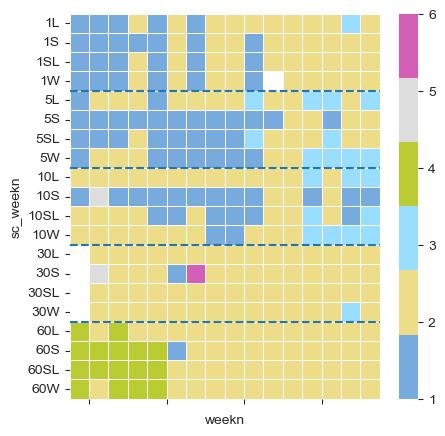

In [43]:
sns.set_style('ticks')
plt.figure(figsize=(5, 5))


ax = sns.heatmap(glue, fmt='f', yticklabels=True, linewidths=.5, cmap=cmap)
ax.axhline(4, ls='--')
ax.axhline(8, ls='--')
ax.axhline(12, ls='--')
ax.axhline(16, ls='--')

ax.set_xticks(range(1, 16, 4))

plt.savefig('outputs/heatmap_'+comm+'top1_chloroplast.png', bbox_inches='tight', dpi=300)

plt.show()

#### Longitudinal analysis of top 3 taxa

Run these lines only for the 18S rRNA analysis

In [ ]:
#18S has many more classes as top values to
top518s = topd['Class'].value_counts()[:4].index.tolist()

In [ ]:
topd.loc[~topd["Class"].isin(top518s), "Class"] = "Other"

In [ ]:
newdf = topd.groupby(['size_code', 'depth','weekn'])['Class'].apply(lambda x: list(set(x)))
newdf = newdf.reset_index()

In [ ]:
result = newdf.copy()

In [ ]:
result = newdf.Class.sort_values().apply(lambda x: sorted(x))
result = pd.DataFrame(result).reset_index(drop=True)

In [ ]:
result.Class.apply(tuple).unique()

In [ ]:
topd['Class'].unique()

In [ ]:
type_dic = {
    'c__Cryptophyceae':1, 'c__Dinophyceae':2, 'c__Prymnesiophyceae':3,
       'c__Mediophyceae':4, 'c__Monogononta':5, 'c__Tentaculata':6,
       'c__Maxillopoda':7, 'c__Thecofilosea':8, 'Unassigned':9, 'c__Insecta':10,
       'c__MAST-2':11, 'c__Hydrozoa':12, 'c__Syndiniales':13,
       'c__Intramacronucleata':14, 'c__Pucciniomycetes':15,
       'c__Mamiellophyceae':16, 'c__Raphidophyceae':17, 'c__MAST-1A':18,
       'c__Bicosoecida':19, 'c__Polychaeta':20, 'c__Tremellomycetes':21,
       'c__Embryophyta':22, 'c__Dothideomycetes':23, 'c__Incertae_Sedis':24,
       'c__MAST-7A':25
}

In [ ]:
type_dic = {'Other':5, 'c__Dinophyceae':1, 'c__Mediophyceae':2,
       'c__Intramacronucleata':3, 'c__Syndiniales':4}

In [ ]:
result['liststring'] = result['Class'].apply(lambda x: ','.join(map(str, x)))

In [ ]:
result['liststring'].unique()

In [ ]:
#use this dic if looking at community type by 3 top taxa
type_dic = {'c__Bacteroidia,c__Cyanobacteriia,c__OM190':1,
       'c__Gammaproteobacteria,c__Bacteroidia,c__Cyanobacteriia':2,
       'c__Alphaproteobacteria,c__Bacteroidia,c__Cyanobacteriia':3,
       'c__Bacteroidia,c__Cyanobacteriia,c__Planctomycetes':4,
       'c__Bacteroidia,c__Alphaproteobacteria,c__OM190':5,
       'c__Bacteroidia,c__OM190,c__Planctomycetes':6,
       'c__Gammaproteobacteria,c__Bacteroidia,c__OM190':7,
       'c__Gammaproteobacteria,c__Bacteroidia,c__Planctomycetes':8,
       'c__Cyanobacteriia,c__OM190,c__Planctomycetes':9,
       'c__Alphaproteobacteria,c__Gammaproteobacteria,c__Cyanobacteriia':10,
       'c__Gammaproteobacteria,c__Bacteroidia,c__Alphaproteobacteria':11,
       'c__Bacteroidia,c__Alphaproteobacteria,c__Cyanobacteriia':12,
       'c__Nitrososphaeria,c__Gammaproteobacteria,c__Bacteroidia':13,
       'c__Gammaproteobacteria,c__Alphaproteobacteria':14,
       'c__Cyanobacteriia':15}

In [ ]:
#make a season column
topd['comm_type'] = ''

for tx, ctype in type_dic.items():
    topd.loc[topd['Class'] == tx, 'comm_type'] = ctype
    
topd

In [ ]:
result['comm_type'] = ''

for tx, ctype in type_dic.items():
    result.loc[result['liststring'] == tx, 'comm_type'] = ctype
    
result

In [ ]:
topd = result.copy()

In [ ]:
topd["sc_weekn"] = topd["depth"].astype(str) + topd["size_code"]
topd

In [ ]:
topd = topd.sort_values(['depth', 'size_code'])

In [ ]:
topdlist = topd['sc_weekn'].tolist()

def uniqlist(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

mylist = uniqlist(topdlist)

In [ ]:
glue = topd.pivot(index="sc_weekn", columns="weekn", values="comm_type")
glue = glue.reindex(mylist)
glue = glue[glue.columns].astype(float)

In [ ]:
 '#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#BBCC33', '#AAAA00', '#DDDDDD'.

In [ ]:
from matplotlib.colors import ListedColormap
cmap_dict = {1: '#77AADD', 2: '#EEDD88', 3: '#99DDFF', 4: '#BBCC33', 5:'#DDDDDD'}
cmap = ListedColormap([cmap_dict[i] for i in range(1,6,1)])

In [ ]:
cmap_dict ={1:'#125A56', 2:'#00767B', 3:'#238F9D', 4:'#42A7C6', 5:'#60BCE9',
            6:'#9DCCEF', 7:'#C6DBED', 8:'#DEE6E7', 9:'#ECEADA', 10:'#F0E6B2',
            11:'#F9D576', 12:'#FFB954', 13:'#FD9A44', 14:'#F57634', 15:'#E94C1F'}#, '#D11807', '#A01813'.
cmap = ListedColormap([cmap_dict[i] for i in range(1,16,1)])

In [ ]:
sns.set_style('ticks')
plt.figure(figsize=(5, 5))


ax = sns.heatmap(glue, fmt='f', yticklabels=True, linewidths=.5, cmap=cmap)
ax.axhline(4, ls='--')
ax.axhline(8, ls='--')
ax.axhline(12, ls='--')
ax.axhline(16, ls='--')

ax.set_xticks(range(1, 16, 4))


plt.savefig('outputs/heatmap_'+comm+'top1class_reducde.png', bbox_inches='tight', dpi=300)

plt.show()

### Taxonomy plotting

In [ ]:
    sfd=separated[separated.depth==depth]
    toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
    toptaxa = toptaxa.drop_duplicates()
    df_agg = toptaxa.groupby(['size_code',level, 'depth']).agg({'feature_frequency':sum})
    topd = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(topn)
    topd = topd.to_frame()
    topd = topd.reset_index()


    df_agg = df_agg.reset_index()
    df_agg['set_name'] = df_agg['size_code']+df_agg['depth'].astype(str)
    
    cumulab = separated[['feature_frequency', 'depth', 'size_code', 'Genus']].copy()
    cumulab1 = cumulab.groupby(['Genus']).agg({'feature_frequency':sum})

    resultpivot = df_agg.pivot_table(index=level, columns='set_name', values='feature_frequency')
    resultpivot = resultpivot.fillna(0)
    resultpivot[resultpivot != 0] = 1
    tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
    tosave.to_csv(level+'_'+str(depth)+'16S_relab.csv')
    
    top10d_list = topd[level].unique()
    top10d = sfd.copy()
    top10d.loc[~top10d[level].isin(top10d_list), level] = 'Other' #isnot in top list
    phyld = top10d.groupby(['size_code','weekn', level])['ratio'].sum()
    phyld = phyld.reset_index()


    fig = px.bar(phyld, x="size_code", y="ratio", facet_col="weekn", color=level, labels={
                     "feature_frequency": "Relative abundance",
                     "size_code": "",
                     "weekn": "w"}, color_discrete_map=palette_dict)
    fig.update_xaxes(type='category', dtick=1)
    fig.update_layout(
        title="Relative abundance of top 10" + level + 'observed at Depth' + str(depth),
        yaxis_title="Relative abundance",
        xaxis_title="Size fraction",
        legend_title=level,
        font=dict(size=8)
    )

    fig.show()
    #fig.write_image("outputs/fig1.png")
    #fig.to_image(format="png")

In [ ]:
phyld, top10d = taxbarplot(newseparated, 'Class', 5, 5)

In [ ]:
plot_df2 = plot_df2.drop_duplicates()

In [ ]:
plot_df3 = plot_df2.set_index('sampleid')
plot_df3

In [ ]:
permanova2 = permanova(dm, plot_df3, 'Size code')
permanova2

In [ ]:
distance_matrix2 = distance_matrix.reset_index()
idedup = distance_matrix2['samples'].to_list()
dm = DistanceMatrix(distance_matrix, ids=idedup)
df123 = dm.to_data_frame()

In [ ]:
df123.to_csv('distance_matrix_5m16s.tsv', sep='\t')

In [ ]:
plot_df2.to_csv('METADATAtiny.txt', sep='\t')

In [ ]:
pca, pca_features, sfdclr = pcaplot(newseparated, 5, comm, 'Size code', 'DFr')

In [ ]:
newmetadata = newseparated[['sampleid', 'weekn', 'size_code', 'depth', 'depth_code', 'month_name']].copy()
newmetadata = newmetadata.drop_duplicates()
newmetadata.to_csv('METADATA.tsv', sep='\t')

In [ ]:
pca_features

In [ ]:
from skbio.stats.distance import permanova

### Stacked bar plots

In [44]:
level = 'feature_id'
if level == 'feature_id':
    id = 'ASV'
else:
    id = level

subtitile = 'subtitle'

/Users/Diana/Documents/escuela/phd/size_fractions/bb2022_functions.py:922: UserWarning:

Glyph 8746 (\N{UNION}) missing from current font.

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 8746 (\N{UNION}) missing from current font.



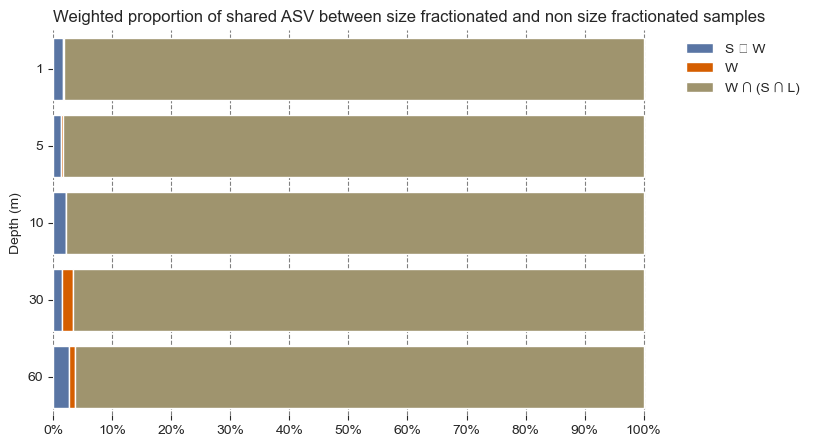

In [45]:
dfplot, level = calcperc(comm, separated, level)
# variables
labels = ['S ∪ W', 'W','W ∩ (S ∩ L)']
colors = ['#5975a4', '#d55e00', '#9F946E']
title = 'Weighted proportion of shared '+id+' between size fractionated and non size fractionated samples'

plot_stackedbar_p(comm, dfplot, labels, colors, title, subtitle, level)

In [ ]:
dfplot, level, dfplot_unweighted = calcperc_defrac_unweighted(comm, separated, level)
# variables
labels = ['Size fractionated samples', 'Not size fractionated samples','Both']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']
title = 'Unweighted proportion of shared '+id+' between size fractionated and non size fractionated samples'

plot_stackedbar_p(comm, dfplot, labels, colors, title, subtitle, level)

In [ ]:
dfplot, level, dfplot_unweighted = calcperc_defrac(comm, newseparated, level, dfplot_unweighted)
# variables
labels = ['SF samples', 'NSF samples','DFr', 'DFr']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#de282e']
title = 'Weighted proportion of shared '+id+' between size fractionated and non size fractionated samples'

plot_stackedbar_p(comm, dfplot, labels, colors, title, subtitle, level)

In [ ]:
dfplotSLNSF, dfplot_normalized, level = calcperc_SLNSF(comm, newseparated, level)
# variables
labels = ['S', 'L','S ∩ L', 'W']
colors = ['#5975a4','#d55e00','#D39473', '#6EAF46']
title = 'Weighted proportion of shared '+ id +' between size fractionated and non size fractionated samples'

plot_stackedbar_p_SLNSF(comm, dfplotSLNSF, labels, colors, title, subtitle, level, 3.1, 0.5)

In [ ]:
dfplotLSW, dfplot_normalized, level = calcperc_LSW(comm, separated, level)
#variables
labels = ['NSF samples', 'Large and whole','Small and whole', 'Large, small, and whole']
colors = ['#8390FA', '#FF0000', '#DAD746', '#E89618']
title = 'Weighted proportion of shared '+ id +' between size fractionated and non size fractionated samples'

plot_stackedbar_p_SLNSF(comm, dfplotLSW, labels, colors, title, subtitle, level)

In [ ]:
dfplotLS_W, dfplot_normalized, level = calcperc_LS_W(comm, separated, level)
#variables
labels = ['NSF samples', 'Large and whole','Small and whole']
colors = ['#8390FA', '#FF0000', '#DAD746']
title = 'Weighted proportion of shared '+ id +' between size fractionated and non size fractionated samples'

plot_stackedbar_p_SLNSF(comm, dfplotLS_W, labels, colors, title, subtitle, level, 45.1, 5)

In [ ]:
newseparated

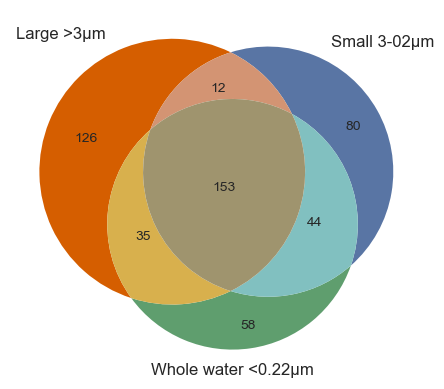

In [46]:
level = 'feature_id'

toptaxa = separated[[level, 'feature_frequency', 'Taxon', 'size_code', 'weekn']].copy()
    
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code',level]).agg({'feature_frequency':sum})
    
df_agg = df_agg.reset_index()
resultpivot = df_agg.pivot_table(index=level, columns='size_code', values='feature_frequency')
resultpivot = resultpivot.fillna(0)
    
df1 = resultpivot.copy()
    
df = resultpivot[['L', 'S', 'W']].copy()
Sonly = df[(df['L'] == 0) & (df['W'] == 0)]
Wonly = df[(df['L'] == 0) & (df['S'] == 0)]
Lonly = df[(df['S'] == 0) & (df['W'] == 0)]
LW = df[(df['S'] == 0) & (df['W'] != 0) & (df['L'] != 0)]
LS = df[(df['W'] == 0) & (df['S'] != 0) & (df['L'] != 0)]
SW = df[(df['W'] != 0) & (df['S'] != 0) & (df['L'] == 0)]
LSW = df[~(df == 0).any(axis=1)]
        
c = venn3(subsets = (len(Lonly), len(Sonly), len(LS), len(Wonly), len(LW), len(SW), len(LSW)), 
          set_labels = ('Large >3μm', 'Small 3-02μm', 'Whole water <0.22μm'),
          #set_colors=('#E56BE5', '#976BE5', '#6EAF46'),
          set_colors=('#d55e00', '#5975a4', '#5f9e6e'), alpha = 1);


plt.savefig("outputs/"+comm+"/D"+level+"_vennall.png", dpi=200, bbox_inches="tight")

** another idea is to run ancom of sizefraction specific and compare after the categories (run ancom on ?time or month.. or some other column) and compare the number/taxonomy of differentially abundant taxa recovered;
are we recovering the same diff ab taxa between the (1.SF samples, 2. NSF samples)

/Users/Diana/Documents/escuela/phd/size_fractions/bb2022_functions.py:461: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Components =  2 ;
Total explained variance =  0.68243
Components 1 and 2 are [0.40554871 0.27688588]


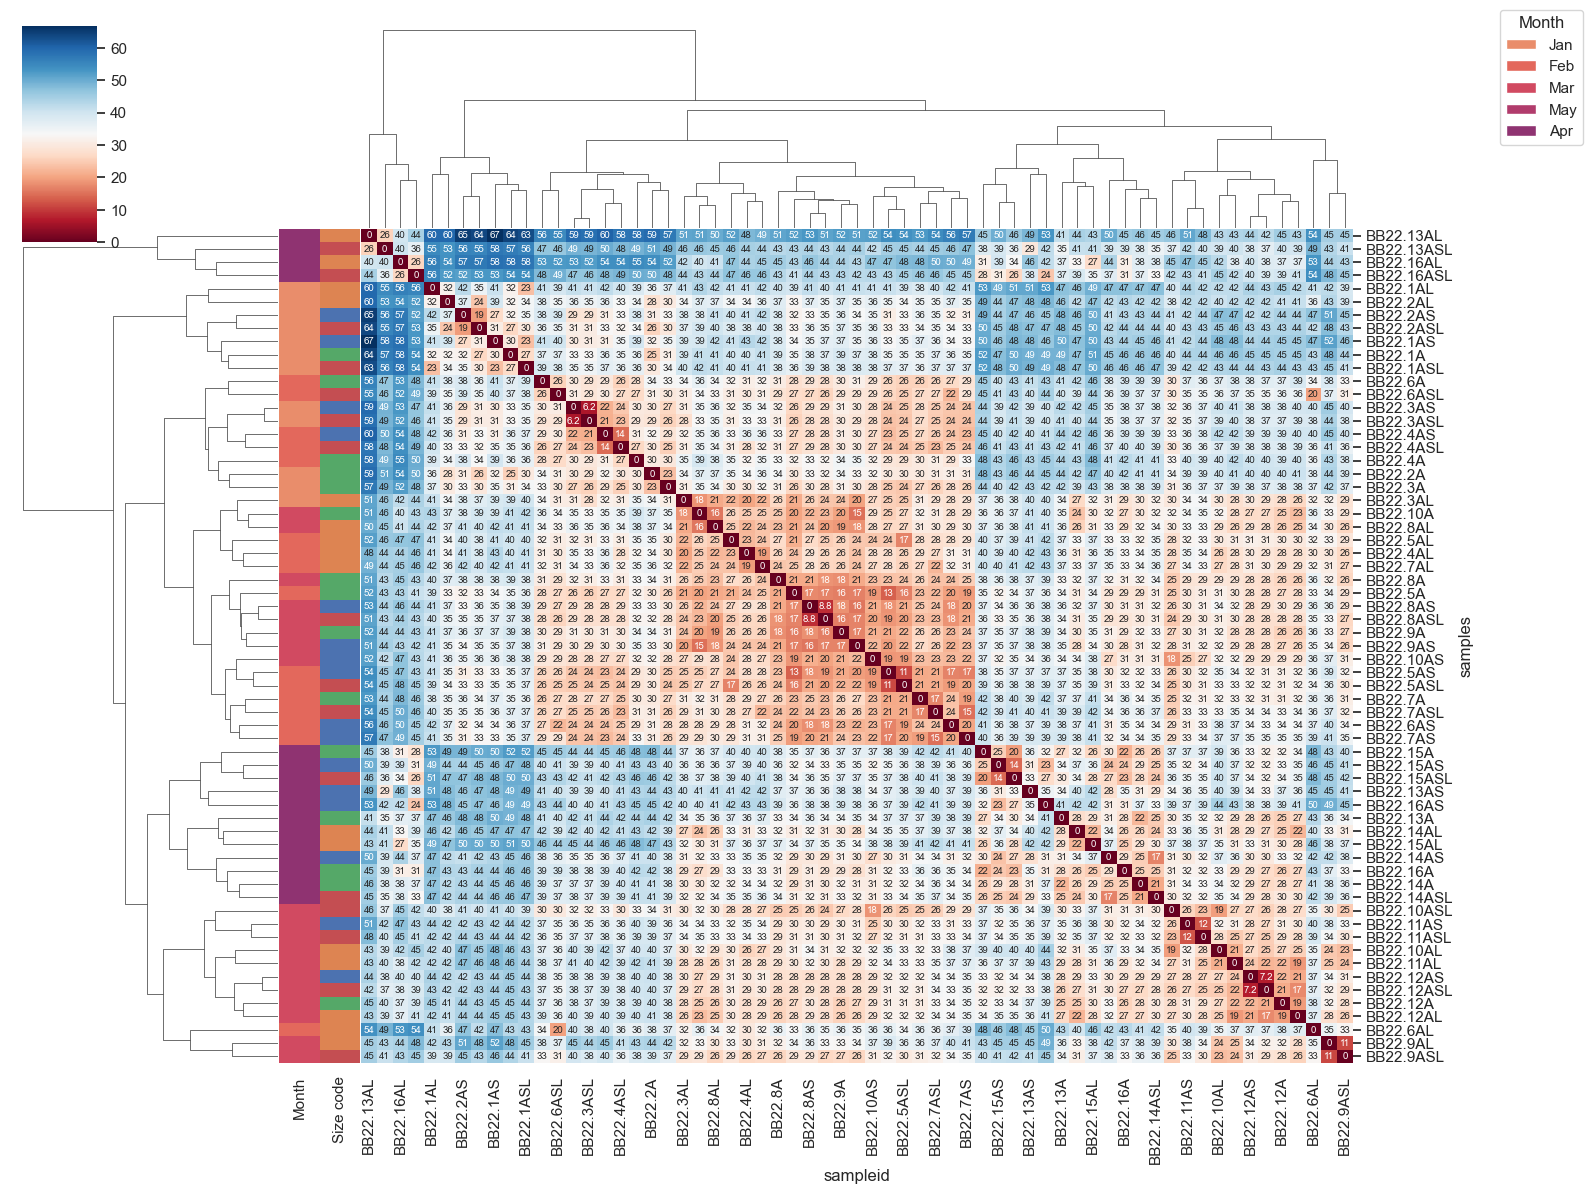

In [ ]:
pca, pca_features, sfdclr = pcaplot(newseparated, 1, comm, 'Size code', 'DFr')

In [ ]:
newbiom = d1.pivot_table(index="feature_id", columns="sampleid", values="feature_frequency")
newbiom = newbiom.fillna(0)
newbiom.to_csv('newbiomdepth1.tsv', sep="\t") 

## 16S ANCOM PER DEPTH

In [ ]:
onlyDFRW = newseparated[newseparated.size_code != 'L']

In [47]:
onlyDFRW = newseparated.copy()

#### rank taxon by abundance: 

In [48]:
#onlyDFRW['Rank'] = df['ratio'].rank(axis=0, method='average')
onlyDFRW["rank"] = onlyDFRW.groupby("sampleid")["ratio"].rank(method="average", ascending=False)

In [77]:
comm='chloroplast'

/Users/Diana/Documents/escuela/phd/size_fractions/bb2022_functions.py:461: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Components =  2 ;
Total explained variance =  0.69482
Components 1 and 2 are [0.532887   0.16193258]


/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



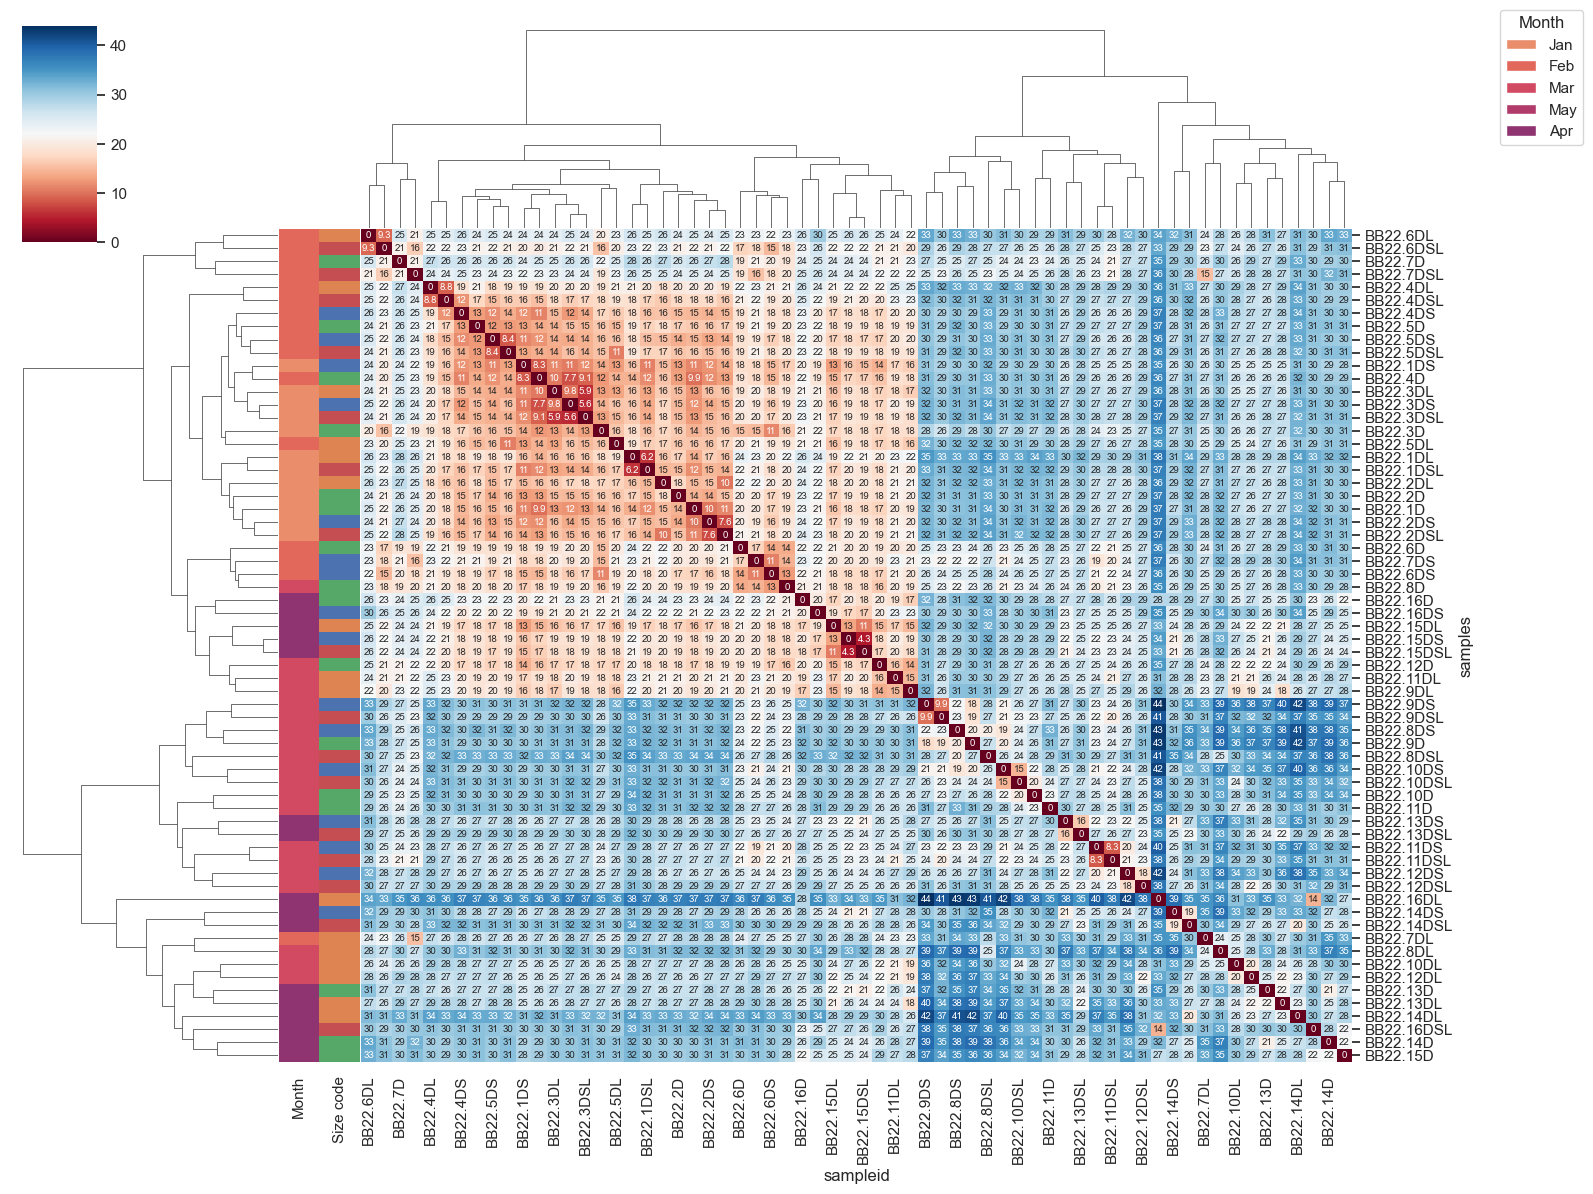

In [ ]:
dep=60
pca1_16, pca_features1_16, sfdclr1_16 = pcaplot(onlyDFRW, dep, comm, 'size_code', 'DFr')
DARejected_SC_taxonomy1_16, prcentile1_16 = run_ancom(onlyDFRW, sfdclr1_16, dep, 'size_code')

In [88]:
DARejected_60_chloro = DARejected_SC_taxonomy1_16

In [86]:
DARejected_30_chloro

,feature_id,W,Reject null hypothesis,Confidence,Taxon,Phylum,Class,Family,Genus,Species
0,2981aa9f69bc423dc502b2e178dc7904,220,True,0.851017,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__Micromonas_commoda
1,64b2411ef91c0e6c019f500c69cbbe03,213,True,1.000000,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,Unassigned
2,6c987094eb76bff568a4499383aa85e6,213,True,0.991878,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__unidentified_cryptomonad
3,a8651618911e5bb5d1066e5abca8f322,220,True,0.999988,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__Bathycoccus_prasinos
4,e7da1335cc9023e506df6af40d7ee069,207,True,0.945267,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,p__Proteobacteria,c__Alphaproteobacteria,f__Mitochondria,g__Mitochondria,s__uncultured_bacterium
5,edd3ec021d2822a47beeb4cb65023760,205,True,1.000000,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,Unassigned


In [83]:
DARejected_10_chloro

,feature_id,W,Reject null hypothesis,Confidence,Taxon,Phylum,Class,Family,Genus,Species
0,232219084f234c1b31d90324e6d1832f,256,True,1.000000,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,Unassigned
1,2981aa9f69bc423dc502b2e178dc7904,267,True,0.851017,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__Micromonas_commoda
2,2f72a212b9a2db1f2d4b1693515b67a1,250,True,0.971677,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,p__Proteobacteria,c__Alphaproteobacteria,f__Mitochondria,g__Mitochondria,s__uncultured_bacterium
3,6c987094eb76bff568a4499383aa85e6,252,True,0.991878,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__unidentified_cryptomonad
4,a8651618911e5bb5d1066e5abca8f322,277,True,0.999988,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__Bathycoccus_prasinos
5,e7da1335cc9023e506df6af40d7ee069,258,True,0.945267,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,p__Proteobacteria,c__Alphaproteobacteria,f__Mitochondria,g__Mitochondria,s__uncultured_bacterium
6,edd3ec021d2822a47beeb4cb65023760,254,True,1.000000,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,Unassigned


In [79]:
DARejected_5_chloro

,feature_id,W,Reject null hypothesis,Confidence,Taxon,Phylum,Class,Family,Genus,Species
0,232219084f234c1b31d90324e6d1832f,255,True,1.000000,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,Unassigned
1,2981aa9f69bc423dc502b2e178dc7904,256,True,0.851017,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__Micromonas_commoda
2,2f72a212b9a2db1f2d4b1693515b67a1,231,True,0.971677,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,p__Proteobacteria,c__Alphaproteobacteria,f__Mitochondria,g__Mitochondria,s__uncultured_bacterium
3,a8651618911e5bb5d1066e5abca8f322,254,True,0.999988,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__Bathycoccus_prasinos


In [73]:
DARejected_1_chloro

,feature_id,W,Reject null hypothesis,Confidence,Taxon,Phylum,Class,Family,Genus,Species
0,2981aa9f69bc423dc502b2e178dc7904,263,True,0.851017,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__Micromonas_commoda
1,6c987094eb76bff568a4499383aa85e6,260,True,0.991878,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__unidentified_cryptomonad
2,a8651618911e5bb5d1066e5abca8f322,272,True,0.999988,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,p__Cyanobacteria,c__Cyanobacteriia,f__Chloroplast,g__Chloroplast,s__Bathycoccus_prasinos


In [ ]:
DARejected_SC_taxonomy1_16.sort_values(by='W')

In [ ]:
DARejected_SC_taxonomy1_16_with_chloroplast

In [ ]:
prcentile1_16 = prcentile1_16.reset_index()

In [ ]:
prcentile1_16.loc[prcentile1_16['feature_id'] == 'a955e3b357dd61bebe626bf1d0af33c4']

? run a clustermap of top10 taxa of each deapth and color rows by depth, month, size code

In [ ]:
plot_per_fid('16S', separated, 60, '1e7d3a6dba567b1bcc4e6ceac17cec6d')

In [ ]:
plot_df2.sort_values('dim1')

Permanova results from R into boxplots

In [ ]:
permresu = pd.read_csv('R_results/post_hoc_results.csv')

In [ ]:
permresu["depth_pairs"] = permresu["depth"].astype(str) + permresu["pairs"]

In [ ]:
ax = sns.catplot(
    permresu, kind="bar",
    x="p.adjusted", y="pairs", col="comm", hue="depth",
    height=4, aspect=1.3, palette="Greys", log=True
)
#ax.set(xlim=(0, 0.10))

ax.refline(x=0.05, color='red')

plt.savefig('outputs/perm_pvalues_logged.png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
ax = sns.catplot(
    permresu, kind="bar",
    x="p.adjusted", y="pairs", col="comm", hue="depth",
    height=4, aspect=1.3, palette="Greys", log=True
)
#ax.set(xlim=(0, 0.10))

ax.refline(x=0.05, color='red')

plt.savefig('outputs/perm_pvalues_logged.png', bbox_inches='tight', dpi=300)

plt.show()

### Group-specific time series

In [ ]:
d1 = newseparated[newseparated.depth == 1]

In [ ]:
d1.loc[d1["feature_id"] == f_id].iloc[0]["rank"]

In [ ]:
d = dep
f_id = 'a955e3b357dd61bebe626bf1d0af33c4'

d1 = onlyDFRW[onlyDFRW.depth == d]
d1_fid = d1[d1.feature_id == f_id]
tax = d1.loc[d1["feature_id"] == f_id].iloc[0]["Taxon"]
rk = d1.loc[d1["feature_id"] == f_id].iloc[0]["rank"]

sizecodes = ['S', 'L', 'W', 'SL']
palette_colors = sns.color_palette()
palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}

sns.set(rc={"figure.figsize":(7, 4)})
sns.set_style("ticks")
ax = sns.lineplot(data = d1_fid, x='weekn', y='ratio', hue='size_code', palette=palette_dict, style='size_code')
plt.legend(title='Size code')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
#sns.despine()

plt.ylabel('Relative abundance', fontsize=12)
plt.xlabel('Time (week)', fontsize=12)
plt.title('Relative abundance of '+ tax + '('+ str(rk) +')')

plt.savefig('outputs/'+comm+'/D'+str(d)+'_lineplot'+ tax +'ancom.png', dpi=200, bbox_inches="tight")

In [ ]:
d1.loc[d1["feature_id"] == f_id].iloc[0]["size_code"]

In [ ]:
d1.sort_values('ratio')